# Analysis on correlation between earthquakes and surface mass loading in individual mascons

In [264]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from global_land_mask import globe
import scipy.stats as stats
import os
import importlib
import geopandas as gpd
# from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
import numpy.ma as ma

# file containing functions:
import loadquakes
importlib.reload(loadquakes)

<module 'loadquakes' from '/Users/amandasyamsul/SLIQ/loadquakes.py'>

In [2]:
# import sys
# !{sys.executable} -m pip install netcdf4

## 1. Load datasets

- GRACE and GRACE-FO
- USGS earthquake catalog with ETAS probabilities

In [3]:
# GRACE data
ds = xr.open_dataset("GRCTellus.JPL.200204_202201.GLO.RL06M.MSCNv02CRI.nc")

# Catalog of events from 2002-04-16 to 2022-1-16 with magnitude >= 5.4
catalog = pd.read_csv('ind_and_bg_probs.csv')
catalog["time"] = catalog["time"].astype("datetime64[ns]")

In [4]:
# This is the catalog with all details from the USGS Earthquake Catalog

original_catalog = pd.read_csv('19970101-20220116.csv')
original_catalog = original_catalog[original_catalog['time']>'2002-04-16']
original_catalog = original_catalog[original_catalog['time']<'2022-01-16']
cat = original_catalog.reset_index()

In [5]:
depth = cat['depth']
catalog['depth'] = depth

## 2. Using Mizrahi's ETAS code, filter events that that have less than 90% chance of being triggered
##### The mean probability of being triggered (P_triggered) for the catalog is 97.97% with a standard deviation of 9.25% . Here, we examine events that have less 90% probability of being triggered by another earthquake

In [6]:
etas_declustered = catalog[catalog['P_triggered']<.9]

## 3. Add surface load data to the earthquake dataframes

In [7]:
def get_mass(eq):
    mass_change = ds.sel(lat=(eq["latitude"]),lon=(eq["longitude"]),time=(eq["time"]), method="nearest")
    mass_change = mass_change["lwe_thickness"]
    return mass_change.data
  
etas_declustered['dmass'] = etas_declustered.apply(lambda row: get_mass(row), axis=1)
catalog['dmass'] = catalog.apply(lambda row: get_mass(row), axis=1)

/var/folders/8d/yjj_j8x10pd63nrz4jt7rhrh0000gn/T/ipykernel_57364/3089949731.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  etas_declustered['dmass'] = etas_declustered.apply(lambda row: get_mass(row), axis=1)


In [8]:
# etas_declustered.to_csv('etas_declustered.csv')

In [9]:
# catalog.to_csv('catalog.csv')

#### Are the mean/meadian values different between: 1. The whole dataset, 2. times with earthquakes, and 3. times with earthquakes that have low probability of being triggered?
The answer appears to be: no, not really. The Bayesian analysis explains why! It's because the declustered catalog are favored at large positive AND negative surface loads. The symmetry implies that the means don't change much.

In [8]:
print('ETAS declustered mean:   %f'%etas_declustered['dmass'].mean())
print('ETAS declustered median: %f'%etas_declustered['dmass'].median())

print('Earthquake mean:   %f'%catalog['dmass'].mean())
print('Earthquake median:   %f'%catalog['dmass'].median())

print(ds.lwe_thickness.mean())
print(ds.lwe_thickness.median())

ETAS declustered mean:   0.441004
ETAS declustered median: 0.284740
Earthquake mean:   0.827411
Earthquake median:   1.054229
<xarray.DataArray 'lwe_thickness' ()>
array(-0.65387518)
<xarray.DataArray 'lwe_thickness' ()>
array(0.7491707)


## 4. Analyze correlation between all events and surface mass loading

In [11]:
# takes a long time to run (has already been run for 2002-04-16 to 2022-01-16)

# loadquakes.calc_stats(np.array(catalog.dmass),np.array(ds['lwe_thickness'].data.flatten()))

### Statistics:
    
- CramerVonMisesResult(statistic=18.386893296385097, pvalue=3.1430320568404113e-09),
- KstestResult(statistic=0.05779103923331644, pvalue=6.212789284386416e-37),
- 'median_all': 0.749170696239575,
- 'median_eq': array(1.05422887),
- 'mean_all': -0.65387517841372,
- 'mean_eq': 0.8274112789242835,
- 'mean_all_minus_mean_eq': -1.4812864573380033,
- 'median_all_minus_median_eq': -0.30505817015141257}

### What we previously did:

Conditional probability for each event is the P(L|E) divided by P(L). The L|E are the loads at the times of an earthquake, while L are the loads at all times globally. 

`def get_cond_probability(all_time_periods, earthquake_only, loads, method):`
    
    cp,bins = calculate_bayes(earthquake_only,all_time_periods,method)

    cp_for_each_event = []
    
    for load in loads:
        
        this_bin = bins[0]
        i = 0
        while this_bin < load:
            if i == len(cp):
                break
            else:
                i = i + 1
                this_bin = bins[i]
        cp_for_each_event.append(cp[i-1])
        
    return np.array(cp_for_each_event)
    

`def calculate_bayes(earthquake_only,all_time_periods,method):`

    bins = calculate_bin_sizes(earthquake_only,method)

    LgE = np.histogram(earthquake_only, bins=bins, density = True)[0]
    L   = np.histogram(all_time_periods,bins=bins, density = True)[0]
    cp = LgE/L

    return cp, bins

### What we are currently doing:

Conditional probability for each event is the P(L|E) by P(L) at the mascon where the earthquake occurred. There is only one L|E taken into account for every event because we are focusing on a specific mascon, and L represents all the loads that have occurred at that specific mascon at all time periods.

`def calculate_probabilities_in_mascons(all_time_periods, earthquake_only, method):`
    
    lat_bounds = ds['lat_bounds'].data
    lon_bounds = ds['lon_bounds'].data
    
    # cp_list = []
    LgE_list = []
    L_list = []

    # Loop through each earthquake in the catalog
    for _, earthquake in earthquake_only.iterrows():
        lat = earthquake['latitude']
        lon = earthquake['longitude']
        dmass = earthquake['dmass']
        
        # Find the mascon corresponding to this earthquake's lat/lon
        lat_idx = np.searchsorted(lat_bounds[:, 0], lat) - 1  # Find the latitude index
        lon_idx = np.searchsorted(lon_bounds[:, 0], lon) - 1  # Find the longitude index
        
        # Ensure lat_idx and lon_idx are within bounds
        lat_idx = np.clip(lat_idx, 0, len(lat_bounds) - 1)
        lon_idx = np.clip(lon_idx, 0, len(lon_bounds) - 1)

        # Extract load data for the mascon (all time periods at this lat/lon)
        lwe_grid = all_time_periods.isel(lat=lat_idx, lon=lon_idx).data.flatten()  # Flatten across time
        
        LgE = dmass
        L = lwe_grid

        LgE_list.append(LgE)  # P(L|E)
        L_list.append(L)  # P(L)
    
    return LgE_list, L_list
    
    
`def get_cp_in_mascon(loads, method):`
    
        bins = loadquakes.calculate_bin_sizes(LgE_list, method)

        LgE = np.histogram(LgE_list, bins=bins, density=True)[0]  # Histogram of dmass (P(L|E))
        L = np.histogram(L_list, bins=bins, density=True)[0]  # Histogram of loads (P(L))

        cp = LgE/L

        cp_for_each_event = []

        for load in loads:

            this_bin = bins[0]
            i = 0
            while this_bin < load:
                if i == len(cp):
                    break
                else:
                    i = i + 1
                    this_bin = bins[i]
            cp_for_each_event.append(cp[i-1])

        return np.array(cp_for_each_event)

## 5. Correlation between earthquakes and surface mass loading

#### Both statistical tests produce p-values < 0.05, which indicate that the two samples are not drawn from the same distribution. This means that the distribution of surface mass load during earthquake occurrence is significantly different from background.

In [389]:
# takes a long time to run (has already been run for 2002-04-16 to 2022-01-16)
# loadquakes.calc_stats(np.array(etas_declustered.dmass),np.array(ds['lwe_thickness'].data.flatten()))

### Statistics

- 'cvm': CramerVonMisesResult(statistic=18.38713838188511, pvalue=3.178242002910281e-09),
- 'ks': KstestResult(statistic=0.0833189806824356, pvalue=0.0010844083570850202),
- 'median_all': 0.749170696239575,
- 'median_eq': array(0.2847398),
- 'mean_all': -0.65387517841372,
- 'mean_eq': 0.44100372833838036,
- 'mean_all_minus_mean_eq': -1.0948789067521003,
- 'median_all_minus_median_eq': 0.46443089594810544}

In [390]:
def calculate_probabilities_in_mascons(all_time_periods, earthquake_only, method):
    
    lat_bounds = ds['lat_bounds'].data
    lon_bounds = ds['lon_bounds'].data
    
    # cp_list = []
    LgE_list = []
    L_list = []

    # Loop through each earthquake in the catalog
    for _, earthquake in earthquake_only.iterrows():
        lat = earthquake['latitude']
        lon = earthquake['longitude']
        dmass = earthquake['dmass']
        
        # Find the mascon corresponding to this earthquake's lat/lon
        lat_idx = np.searchsorted(lat_bounds[:, 0], lat) - 1  # Find the latitude index
        lon_idx = np.searchsorted(lon_bounds[:, 0], lon) - 1  # Find the longitude index
        
        # Ensure lat_idx and lon_idx are within bounds
        lat_idx = np.clip(lat_idx, 0, len(lat_bounds) - 1)
        lon_idx = np.clip(lon_idx, 0, len(lon_bounds) - 1)

        # Extract load data for the mascon (all time periods at this lat/lon)
        lwe_grid = all_time_periods.isel(lat=lat_idx, lon=lon_idx).data.flatten()  # Flatten across time
        
        LgE = dmass
        L = lwe_grid

        LgE_list.append(LgE)  # P(L|E)
        L_list.append(L)  # P(L)
    
    return LgE_list, L_list

In [391]:
def get_cp_in_mascon(loads, method):
    
    bins = loadquakes.calculate_bin_sizes(LgE_list, method)

    LgE = np.histogram(LgE_list, bins=bins, density=True)[0]  # Histogram of dmass (P(L|E))
    L = np.histogram(L_list, bins=bins, density=True)[0]  # Histogram of loads (P(L))

    cp = LgE/L

    cp_for_each_event = []
    
    for load in loads:
        
        this_bin = bins[0]
        i = 0
        while this_bin < load:
            if i == len(cp):
                break
            else:
                i = i + 1
                this_bin = bins[i]
        cp_for_each_event.append(cp[i-1])
        
    cp_for_each_event = np.array(cp_for_each_event)
        
    return cp_for_each_event, cp

### I. ETAS declustered

In [394]:
LgE_list, L_list = calculate_probabilities_in_mascons(ds['lwe_thickness'], etas_declustered, method='fd')
cp_for_each_event, cp = get_cp_in_mascon(np.array(etas_declustered.dmass), 'fd')

In [395]:
etas_declustered.loc[:, 'cp_mascon'] = cp_for_each_event

etas_declustered

,target_id,latitude,longitude,time,magnitude,geometry,mc_current,mc_current_above_ref,mu,P_triggered,P_background,zeta_plus_1,depth,dmass,cp,cp_mascon
10,12,35.2267,31.9435,2022-01-11 01:07:48.064,6.6,POINT (35.2267 31.9435),5.4,0.0,6.907373e-11,0.882599,0.117401,1.0,21.00,-2.2233384958655025,0.918346,0.920536
22,24,-65.3437,-71.5089,2022-01-05 23:24:39.238,5.7,POINT (-65.3437 -71.5089),5.4,0.0,6.907373e-11,0.190957,0.809043,1.0,10.00,4.958630818446542,1.063731,1.136025
53,55,38.9211,92.6190,2021-12-18 23:54:27.150,5.4,POINT (38.9211 92.619),5.4,0.0,6.907373e-11,0.896486,0.103514,1.0,10.00,6.793961883176484,1.461463,1.545328
91,93,31.7230,87.9296,2021-11-30 13:53:41.109,5.5,POINT (31.723 87.92959999999999),5.4,0.0,6.907373e-11,0.866393,0.133607,1.0,6.77,7.550109053771179,1.461463,1.545328
107,109,82.1308,-17.6567,2021-11-23 12:04:19.226,5.4,POINT (82.13079999999999 -17.6567),5.4,0.0,6.907373e-11,0.519118,0.480882,1.0,10.00,3.6251780333983366,0.969398,1.080326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12552,12554,86.0050,31.5950,2002-05-03 11:20:51.540,5.6,POINT (86.005 31.595),5.4,0.0,6.907373e-11,0.285884,0.714116,1.0,10.00,-2.2577669692509024,0.918346,0.920536
12554,12556,1.7930,-102.0700,2002-04-28 20:16:59.340,5.6,POINT (1.793 -102.07),5.4,0.0,6.907373e-11,0.345205,0.654795,1.0,10.00,-0.7484010941932258,1.092622,1.189902
12559,12561,34.6420,47.4000,2002-04-24 19:48:07.120,5.4,POINT (34.642 47.4),5.4,0.0,6.907373e-11,0.707326,0.292674,1.0,33.00,9.932075673016389,1.146392,1.049656
12561,12563,42.4360,21.4660,2002-04-24 10:51:50.930,5.7,POINT (42.436 21.466),5.4,0.0,6.907373e-11,0.656599,0.343401,1.0,10.00,-5.129024438261291,1.591540,1.188973


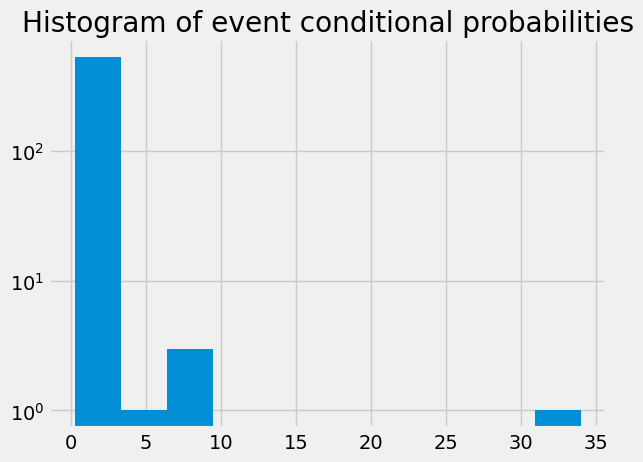

In [396]:
# ETAS declustered

fig,ax=plt.subplots()
plt.hist(etas_declustered.cp_mascon,11)
plt.title('Histogram of event conditional probabilities')
plt.yscale('log')

#### The conditional probability will change quantitatively depending on the bin size. However, the same qualitative distribution remains, where there is a higher relative conditional probability during periods of large loading and unloading. 

#### Here, we calculate the Bayesian probability using two different bin sizes which are calculated via two methods:

##### a. Sturge's Rule
##### b. Freedman-Diaconis Rule


In [397]:
def plot_bayes_mascon(ax, earthquake_only, title, xlab, method, fs):
    plt.style.use('fivethirtyeight')
    
    cp_for_each_event, cp = get_cp_in_mascon(earthquake_only, method)
    bins = loadquakes.calculate_bin_sizes(LgE_list, method) 
    wid = np.mean(np.diff(bins))
    
    print(len(bins))
    print(len(cp))
    
    ax.bar(bins[:-1], cp, width=wid, align='edge')

    xl = ax.get_xlim()
    ax.set_xlim(xl[0], xl[1] - 4.4)
    ax.set_xlabel(xlab, fontsize=fs)
    ax.set_ylabel('Conditional probability', fontsize=fs)
    ax.set_title(title, fontsize=fs)

21
20
71
70


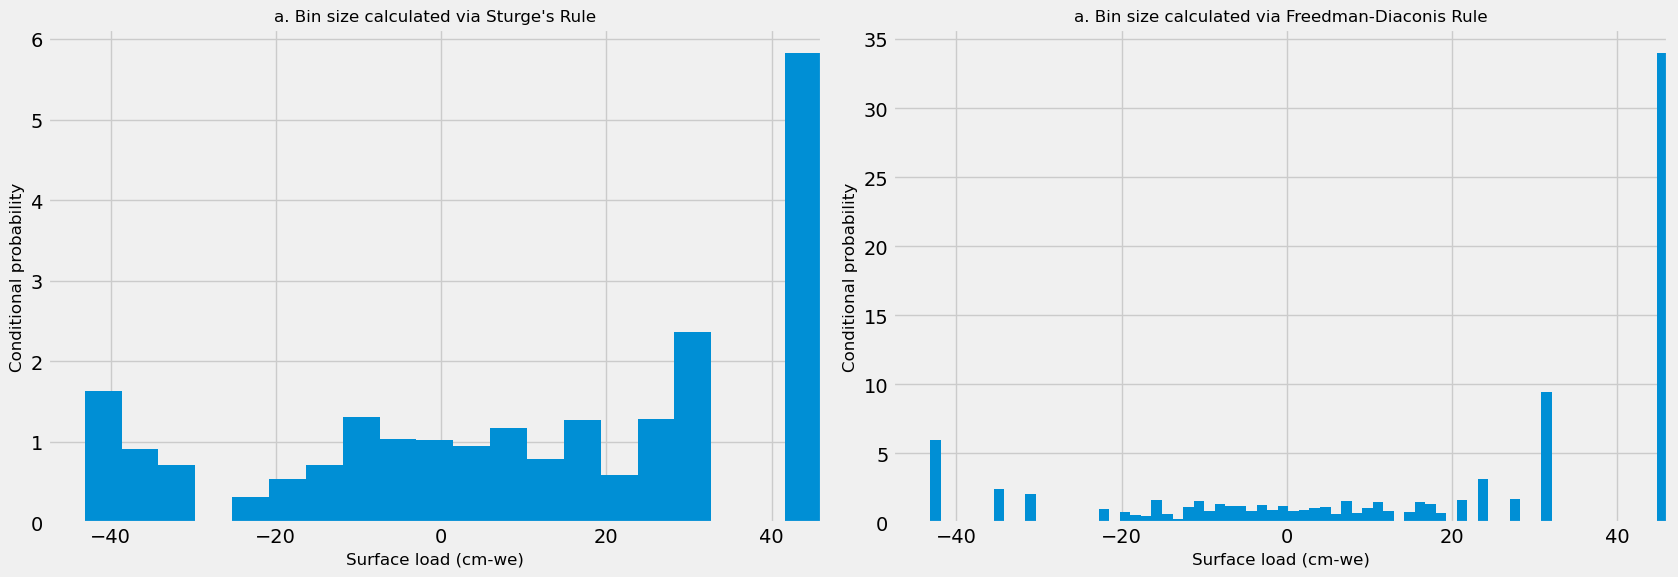

In [398]:
importlib.reload(loadquakes)
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(17,6))

plt.style.use('fivethirtyeight')

plot_bayes_mascon(ax1, np.array(etas_declustered.dmass), 
                  "a. Bin size calculated via Sturge's Rule", 
                  'Surface load (cm-we)', 
                  method='Sturge', fs=12)

plot_bayes_mascon(ax2, np.array(etas_declustered.dmass), 
                  "a. Bin size calculated via Freedman-Diaconis Rule", 
                  'Surface load (cm-we)', 
                  method='fd', fs=12)

fig.tight_layout()

### II. Full catalog

In [405]:
LgE_list, L_list = calculate_probabilities_in_mascons(ds['lwe_thickness'], catalog, method='fd')
cp_for_each_event, cp = get_cp_in_mascon(np.array(catalog.dmass), 'fd')

catalog.loc[:, 'cp_mascon'] = cp_for_each_event

catalog

/var/folders/8d/yjj_j8x10pd63nrz4jt7rhrh0000gn/T/ipykernel_57364/876446557.py:8: RuntimeWarning: invalid value encountered in divide
  cp = LgE/L


,target_id,latitude,longitude,time,magnitude,geometry,mc_current,mc_current_above_ref,mu,P_triggered,P_background,zeta_plus_1,depth,dmass,cp,cp_mascon
0,2,-55.5113,-128.4388,2022-01-15 18:23:04.127,5.7,POINT (-55.5113 -128.4388),5.4,0.0,6.907373e-11,0.998822,1.178415e-03,1.0,10.00,4.971506058424656,0.939436,0.775534
1,3,-20.5460,-175.3900,2022-01-15 04:14:45.000,5.8,POINT (-20.546 -175.39),5.4,0.0,6.907373e-11,0.998325,1.674875e-03,1.0,0.00,2.485465024590889,1.146643,1.065946
2,4,-7.0422,105.2063,2022-01-14 09:49:20.820,5.4,POINT (-7.0422 105.2063),5.4,0.0,6.907373e-11,0.999999,6.002016e-07,1.0,34.46,0.5277498589169527,1.068970,1.047165
3,5,-6.8600,105.2887,2022-01-14 09:05:41.461,6.6,POINT (-6.86 105.2887),5.4,0.0,6.907373e-11,0.996362,3.637987e-03,1.0,33.00,0.5277498589169527,1.068970,1.047165
4,6,-6.6002,147.3665,2022-01-12 13:16:21.730,5.6,POINT (-6.6002 147.3665),5.4,0.0,6.907373e-11,0.998980,1.020001e-03,1.0,80.00,2.113893922464259,1.031600,0.972619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12568,12570,-16.3820,173.2590,2002-04-20 15:59:57.860,6.0,POINT (-16.382 173.259),5.4,0.0,6.907373e-11,0.981736,1.826392e-02,1.0,33.00,-1.6499232850367236,0.830483,0.806029
12569,12571,17.2330,-101.2500,2002-04-18 17:57:27.700,5.9,POINT (17.233 -101.25),5.4,0.0,6.907373e-11,0.999974,2.606205e-05,1.0,33.00,-2.669668663359428,0.792210,0.936323
12570,12572,-27.5350,-70.5860,2002-04-18 16:08:36.780,6.7,POINT (-27.535 -70.586),5.4,0.0,6.907373e-11,0.978985,2.101521e-02,1.0,62.00,-1.9343003050948298,0.788454,0.932636
12571,12573,-60.6570,-25.8430,2002-04-18 14:17:23.940,5.8,POINT (-60.657 -25.843),5.4,0.0,6.907373e-11,0.999386,6.138115e-04,1.0,10.00,-2.905379948482504,0.762105,0.914317


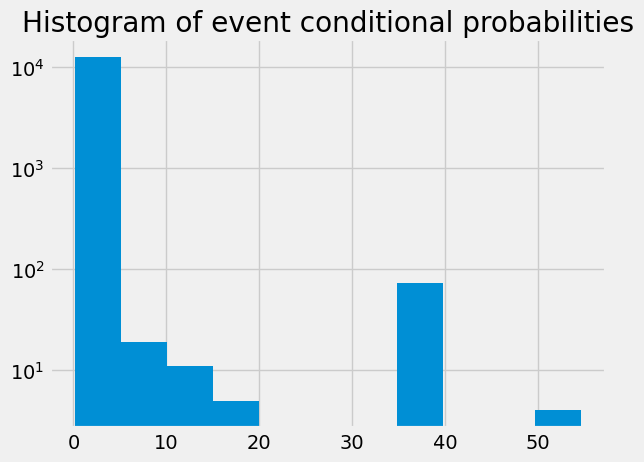

In [406]:
# full catalog

fig,ax=plt.subplots()
plt.hist(catalog.cp_mascon,11)
plt.title('Histogram of event conditional probabilities')
plt.yscale('log')

32
31


/var/folders/8d/yjj_j8x10pd63nrz4jt7rhrh0000gn/T/ipykernel_57364/876446557.py:8: RuntimeWarning: invalid value encountered in divide
  cp = LgE/L


402
401


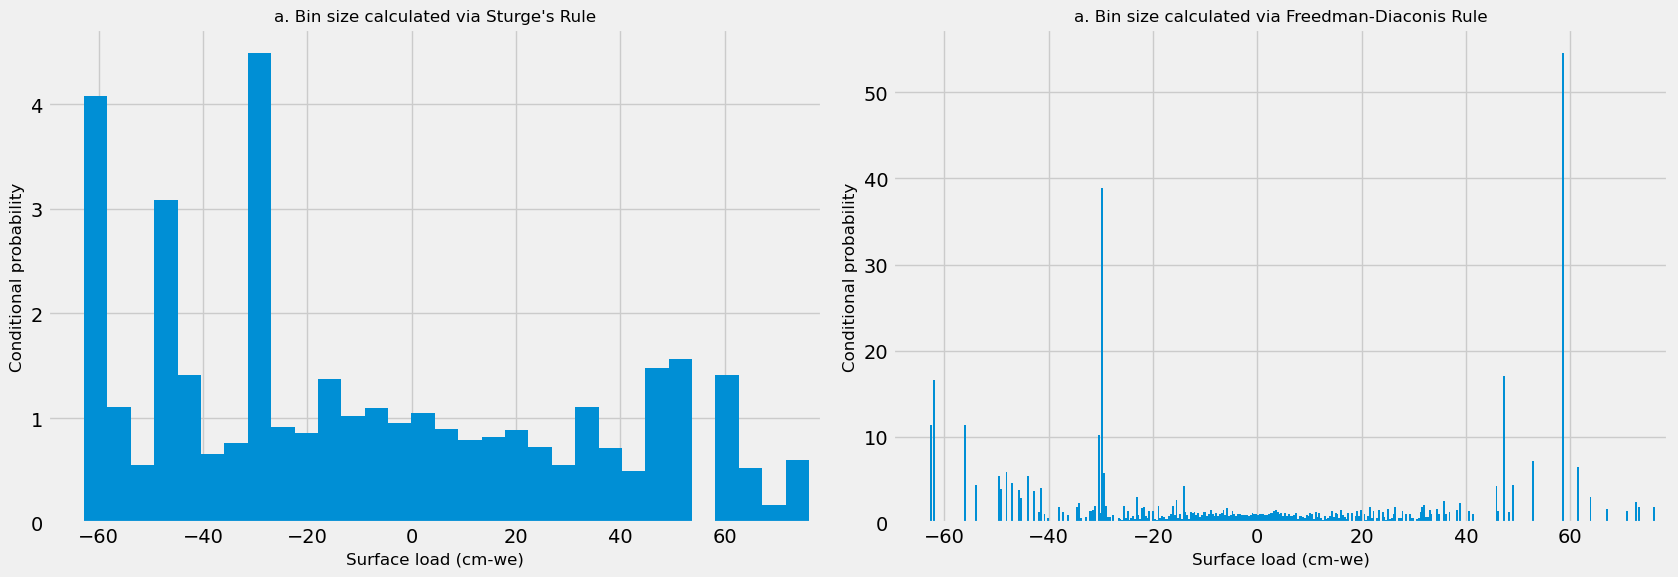

In [407]:
importlib.reload(loadquakes)
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(17,6))

plt.style.use('fivethirtyeight')

plot_bayes_mascon(ax1, np.array(catalog.dmass), 
                  "a. Bin size calculated via Sturge's Rule", 
                  'Surface load (cm-we)', 
                  method='Sturge', fs=12)

plot_bayes_mascon(ax2, np.array(catalog.dmass), 
                  "a. Bin size calculated via Freedman-Diaconis Rule", 
                  'Surface load (cm-we)', 
                  method='fd', fs=12)

fig.tight_layout()